In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.getcwd()

#change working directory
os.chdir('F:\\FISH')
os.getcwd()

'F:\\FISH'

In [2]:
colnames = ['Chromosome', 'Start', 'End', 'Name', 'Sequence', 'Tot_hits', 'GC', 'Tm']
phase1 = "/FISH/CTRL_L/CTRL_L_hg38_phase1.bed"
phase1 = pd.read_csv(phase1, names=colnames, sep='\t', header=None)
phase1["Sequence"] = phase1["Sequence"].str.upper()

In [3]:
colnames2 = ['Chromosome', 'Start', 'End', 'Name', '20nt_hits', 'Align', 'Chromosome_targets', 'Mismatches', 'html']
phase2 = "/FISH/CTRL_L/CTRL_L_hg38_phase2.bed"
phase2 = pd.read_csv(phase2, names=colnames2, sep='\t', header=None)
phase2 = phase2.drop(columns=['html'])

In [4]:
# Merge pahse1 and phase2 on the names (by setting them as index)
# inner join only keeps names that are in both data frames
df = phase2.set_index('Name').join(phase1.set_index('Name')[['Sequence','Tot_hits','GC', 'Tm']], how='inner')
df.reset_index(inplace=True)

In [5]:
# Remove sequences with too many hit over 20nt, STANDARD MAX 3
# Remove sequences with more than 1 target in chr3 (target chromosome)
# Remove targets on translocated chromosome

df = df[~df['Chromosome_targets'].str.contains("chr3\(")] 
df = df[~df['Chromosome_targets'].str.contains("chr8")]
df = df[~df['Chromosome_targets'].str.contains("chr8\(")]

df.reset_index(drop=True, inplace=True)

In [6]:
df_1000_3 = df.copy()
df_1000_3 = df_1000_3[(df_1000_3['Tot_hits']<1000)]
df_1000_3 = df_1000_3[df_1000_3['20nt_hits']<3]

In [7]:
overhang = "GCTATCGTTCGTTCGAGGCC"
df_1000_3["Sequence with Overhang"] = overhang + df_1000_3["Sequence"]
df_1000_3

,Name,Chromosome,Start,End,20nt_hits,Align,Chromosome_targets,Mismatches,Sequence,Tot_hits,GC,Tm,Sequence with Overhang
1,CTRL_L_8,chr3,169000047,169000087,1,40,chr3,0,CACTCAGTTTGGGATGGGAGTTTAGCTATCTTCTTTCCAG,97,45.0,69.931690,GCTATCGTTCGTTCGAGGCCCACTCAGTTTGGGATGGGAGTTTAGC...
4,CTRL_L_14,chr3,169000299,169000339,1,40,chr3,0,GTCCTTTCTTTGGTCTTTGCTTTCCACTTTAGCCCTAATG,175,42.5,69.809028,GCTATCGTTCGTTCGAGGCCGTCCTTTCTTTGGTCTTTGCTTTCCA...
5,CTRL_L_15,chr3,169000341,169000381,1,40,chr3,0,AACTATTTTCCTCTCTTCCAAAGGCTTTTTCAGTCCTTCT,256,37.5,68.614881,GCTATCGTTCGTTCGAGGCCAACTATTTTCCTCTCTTCCAAAGGCT...
6,CTRL_L_16,chr3,169000383,169000423,1,40,chr3,0,ATCAGAAGACATTAAAATCCTCCATTGAATCCTCTGACCT,126,37.5,68.023115,GCTATCGTTCGTTCGAGGCCATCAGAAGACATTAAAATCCTCCATT...
7,CTRL_L_17,chr3,169000425,169000465,2,"40,20","chr10,chr3","0,0",GGCTCAGCTCTTTGGCATGGTCTCCTACCATAATTTAAAG,80,45.0,70.449362,GCTATCGTTCGTTCGAGGCCGGCTCAGCTCTTTGGCATGGTCTCCT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,CTRL_L_113,chr3,169004457,169004497,1,40,chr3,0,GGAGGAAGGAGAAGAGAAATAATCTACTATTTTGCCTAGA,534,37.5,66.320844,GCTATCGTTCGTTCGAGGCCGGAGGAAGGAGAAGAGAAATAATCTA...
102,CTRL_L_115,chr3,169004541,169004581,1,40,chr3,0,AAGAGAAGCAAGCAAGGATGAATAGGAAAAGGGCTTTGGA,138,42.5,71.364677,GCTATCGTTCGTTCGAGGCCAAGAGAAGCAAGCAAGGATGAATAGG...
103,CTRL_L_116,chr3,169004583,169004623,1,40,chr3,0,TTGGGGTTGGCCTATAAATGAAAGAAAAGGAAACGGAGAA,520,40.0,70.222211,GCTATCGTTCGTTCGAGGCCTTGGGGTTGGCCTATAAATGAAAGAA...
104,CTRL_L_117,chr3,169004625,169004665,1,40,chr3,0,AATACCTGTCTGACTTATACCTTGCCACAATCTCCTTAAA,59,37.5,67.953849,GCTATCGTTCGTTCGAGGCCAATACCTGTCTGACTTATACCTTGCC...


In [8]:
#load data CTRL_L PaintSHOP
file2 = "/FISH/CTRL_L/CTRL_L_PaintSHOP_default.txt"
colnames2 = ["Chromosome", "Start", "End", "Sequence", "Tm", "On Target", "Off Target", "Repeat Seq", 
             "Prob","Max Kmer", "Probe Strand", "Target"]
df_2 = pd.read_table(file2, names = colnames2, sep='\t')

In [9]:
def coverage(dt,start,end):
    array_T=[]
    
    a_start = dt['Start']
    a_end = dt['End']
    a = list(zip(a_start,a_end))
    
    for pos in range(start,end+1,1):
        for i in a:
            if (pos >= i[0] and pos <= i[1]):
                array_T.append(pos)
                break
    
    coverage = len(array_T)/(end-start+1)*100
    return coverage

coverage(df_2,168999712,169004712)

27.834433113377326

Text(0.5, 1.0, 'CTRL_L')

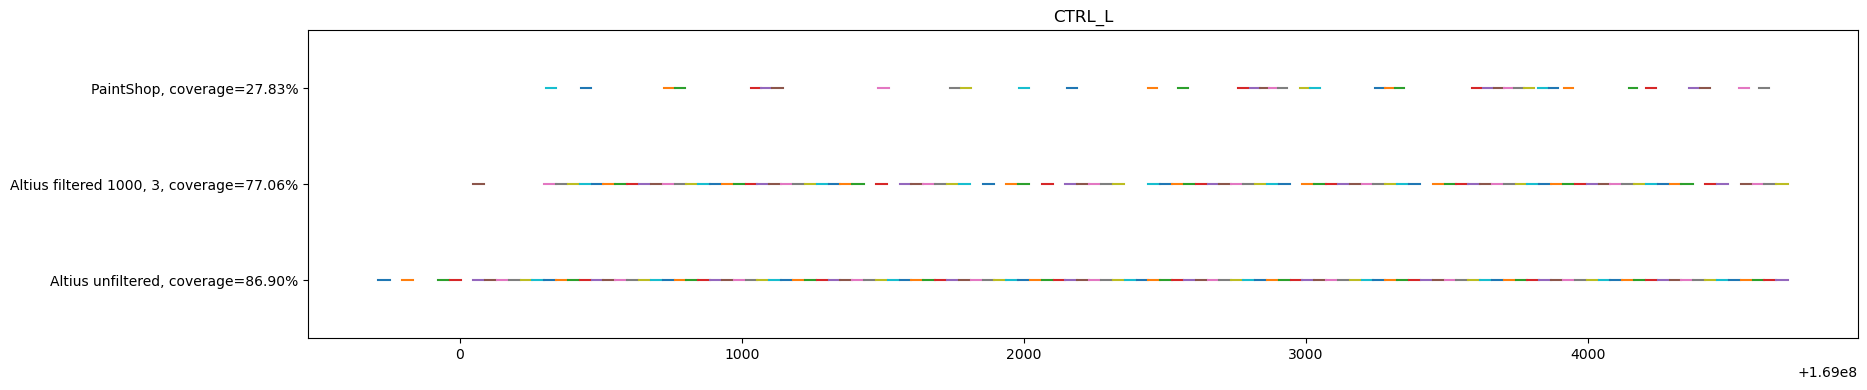

In [10]:
#plot for Altius unfiltered
y_pos = 1
fig, ax = plt.subplots(figsize=(20,4))
for start, end in zip(phase2.Start, phase2.End):
    ax.plot([start, end], [y_pos, y_pos])
    
#plot for Altius filtered 1000 3
y_pos = 2
for start, end in zip(df_1000_3.Start, df_1000_3.End):
    ax.plot([start, end], [y_pos, y_pos])
    
#plot for PaintSHOP
y_pos = 3
for start, end in zip(df_2.Start, df_2.End):
    ax.plot([start, end], [y_pos, y_pos])
    

# bigger margin in y
ax.margins(y=0.3)

ax.set_yticks([1,2,3])
plt.rc('ytick', labelsize=15)
ax.set_yticklabels(['Altius unfiltered, coverage=86.90%', 'Altius filtered 1000, 3, coverage=77.06%', 'PaintShop, coverage=27.83%'])
ax.set_title('CTRL_L')

In [11]:
len(df), len(df_1000_3)

(106, 94)

In [12]:
def overlap_percentage(a,b):
    array_A=[]
    array_B=[]

    s=min(a[0][0],b[0][0])
    l=max(a[len(a)-1][1],b[len(b)-1][1])

    for pos in range(s,l+1,1):
        for i in a:
            if (pos >= i[0] and pos <= i[1]):
                array_A.append(pos)
                break
        for j in b:
            if (pos >= j[0] and pos <= j[1]):
                array_B.append(pos)
                break
    
    intersect_len = len(list(set(array_A) & set (array_B)))
    union_len = len(list(set(array_A) | set (array_B)))
    return intersect_len/union_len*100  

In [13]:
a_start = df_1000_3['Start']
a_end = df_1000_3['End']

b_start = df_2['Start']
b_end = df_2['End']

a = list(zip(a_start,a_end))
b = list(zip(b_start,b_end))

In [14]:
#calculate percentage overlap between Altius filtered and PaintSHOP
overlap_percentage(a,b)

33.045904133908195